In [26]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import gensim
import spacy
from sklearn.model_selection import GridSearchCV

##Task 0 - Dataset
I download a dataset with 17 SDG and filter it to work with SGD16 only. I also preliminary remove all unnecessary symbols from the texts.

In [22]:
df_osdg = pd.read_csv('C:/Users/Anjou/Downloads/osdg-community-data-v2022-10-01.csv', sep='\t')
df_osdg[df_osdg.columns[0].split('\t')] = df_osdg.iloc[:,0].str.split('\t', expand=True)
df_osdg.drop(df_osdg.columns[0], axis=1, inplace=True)

print('Shape:', df_osdg.shape)
print(df_osdg.head())
print(df_osdg[df_osdg['sdg']=='16'])

data = df_osdg.text.values.tolist()
data = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in data]
print(data[:1])

Shape: (37575, 7)
                          doi                           text_id  \
0  10.6027/9789289342698-7-en  00021941702cd84171ff33962197ca1f   
1        10.18356/eca72908-en  00028349a7f9b2485ff344ae44ccfd6b   
2  10.1787/9789264289062-4-en  0004eb64f96e1620cd852603d9cbe4d4   
3     10.1787/5k9b7bn5qzvd-en  0006a887475ccfa5a7f5f51d4ac83d02   
4  10.1787/9789264258211-6-en  0006d6e7593776abbdf4a6f985ea6d95   

                                                text sdg labels_negative  \
0  "From a gender perspective, Paulgaard points o...   5               1   
1  Labour legislation regulates maximum working h...  11               2   
2  The average figure also masks large difference...   3               1   
3  The extent to which they are akin to corruptio...   3               1   
4  A region reporting a higher rate will not earn...   3               2   

  labels_positive           agreement  
0               8  0.7777777777777778  
1               1  0.3333333333333333  
2 

##Task 1 - Topic Modelling and Optimization

For Topic Modelling I decided to use Latent Dirichlet Allocation (LDA). LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities. The purpose of LDA is mapping each document in our corpus to a set of topics which covers a good deal of the words in the document. As it doesn't require training, LDA is a convenient way to get a fast and relatively simple initial approach to the text analysis. LDA gives me a collection of documents that the algorithm has grouped together, as well as clusters of words and expressions that it used to infer these relations.

In [24]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

data_words = list(sent_to_words(data))
print(data_words[:1])

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# Here I remove from data all words except nouns and verbs
data_lemmatized = lemmatization(data_words, allowed_postags=["NOUN", "VERB"]) #select noun and verb
print(data_lemmatized[:2])

[['from', 'gender', 'perspective', 'paulgaard', 'points', 'out', 'that', 'the', 'labour', 'markets', 'of', 'the', 'fishing', 'villages', 'have', 'been', 'highly', 'gender', 'segregated', 'in', 'terms', 'of', 'the', 'existence', 'of', 'male', 'jobs', 'and', 'female', 'jobs', 'however', 'the', 'new', 'business', 'opportunities', 'have', 'led', 'to', 'the', 'male', 'population', 'of', 'the', 'peripheral', 'areas', 'now', 'working', 'in', 'the', 'service', 'industry', 'in', 'former', 'female', 'jobs', 'that', 'boys', 'and', 'girls', 'are', 'doing', 'the', 'same', 'jobs', 'indicates', 'change', 'because', 'traditional', 'boundaries', 'between', 'women', 'and', 'men', 'work', 'are', 'being', 'crossed', 'but', 'the', 'fact', 'that', 'young', 'people', 'are', 'still', 'working', 'represents', 'continuity', 'with', 'the', 'past', 'paulgaard', 'when', 'paulgaard', 'refers', 'to', 'continuity', 'with', 'traditions', 'she', 'refers', 'to', 'the', 'expectations', 'of', 'young', 'adults', 'to', 'par

In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}') 
data_vectorized = vectorizer.fit_transform(data_lemmatized)


lda_model = LatentDirichletAllocation(n_components=20,max_iter=10,learning_method='online',random_state=100,batch_size=128,evaluate_every = -1,n_jobs = -1,               )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method="online", learning_offset=10.0,
 max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
 n_components=10, n_jobs=-1, perp_tol=0.1,
 random_state=100, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

print(f'The LDA was launched with params: {lda_model.get_params()}')

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [9]:
print("Log Likelihood: ", lda_model.score(data_vectorized)) # Better result is the higher one
print("Perplexity: ", lda_model.perplexity(data_vectorized)) # Better result is the lower one

Log Likelihood:  -15291625.518245563
Perplexity:  3206.432822988328


Now I'm starting to seek optimal hyperparameters for LDA. I could use some sophisticated algorithm from optuna, but here simple greed search works sufficiently well in this case. So I define two lists of parameters for "n_components" and "learning_decay" and launch GridSearch to find the optimal.

In [27]:
# Define Search Param
search_params = {'n_components': [5, 10, 20], 'learning_decay': [0.5, 0.7, 0.9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=31)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
        n_jobs=1,
       param_grid={'n_components': [5, 10], 'learning_decay': [0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
lda_model = best_lda_model

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -3062591.3089826843
Model Perplexity:  2628.097774900861


In [28]:
# building Topic Matrix based on a resulted documents
lda_output = lda_model.transform(data_vectorized)

topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic

def color(val):
 color = "yellow" if val > .1 else "blue"
 return "color: {col}".format(col=color)
def to_bold(val):
 weight = 700 if val > .1 else 400
 return "font-weight: {weight}".format(weight=weight)

df_document_topics = df_document_topic.head(20).style.applymap(color).applymap(to_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.150000,0.000000,0.050000,0.800000,0.000000,3
Doc1,0.090000,0.270000,0.010000,0.450000,0.180000,3
Doc2,0.010000,0.010000,0.930000,0.010000,0.050000,2
Doc3,0.010000,0.260000,0.220000,0.010000,0.510000,4
Doc4,0.010000,0.010000,0.600000,0.310000,0.080000,2
Doc5,0.060000,0.000000,0.510000,0.300000,0.130000,2
Doc6,0.290000,0.330000,0.000000,0.000000,0.370000,4
Doc7,0.270000,0.710000,0.010000,0.010000,0.010000,1
Doc8,0.470000,0.310000,0.200000,0.010000,0.010000,0
Doc9,0.640000,0.240000,0.120000,0.000000,0.000000,0


In [31]:
# Words per each topic visualisation
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Topics = ["Topic_"+str(i) for i in range(lda_model.n_components)]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Topics
Topic 0,water,energy,use,land,production,costs,sector,investment,agricultural,market,Topic_0
Topic 1,development,policy,national,government,countries,public,climate,information,policies,management,Topic_1
Topic 2,countries,health,income,poverty,care,cent,population,average,oecd,rates,Topic_2
Topic 3,women,education,school,work,students,labour,gender,employment,schools,children,Topic_3
Topic 4,law,rights,international,social,human,political,article,public,legal,state,Topic_4


Grid search showed that optimal parameter for n_components is 5, so I consider that 5 topics is the best choise for this data. About the number of the words I consider that 10 worlds is optimal to describe a topic. Sometimes even 5 words are enough but not for all of them. I can formulate topics according to the words:
Topic_0. Energy and natural resources market
Topic_1. Politics
Topic_2. Standard of living
Topic_3. Jobs and Education
Topic_4. Legal and law

##Task 2 - Topic Summarization via Text Summarization/Generation with a Large Language Model

In this task I'm going to generate text summaries using the topics I generated in previous task. I Task_1 I generated 5 topics each of them described by a number of worlds. Based on this words I will generate a text using a ready for use large model. I take a model "distilgpt2" from Hugginface. Distilgpt2 is a lighter version of GPT2 but in this case it should be enough. I downloaded transformers library and use module pipiline to generate text from topics.  

In [39]:
from transformers import pipeline
from wordcloud import WordCloud

In [56]:

# generator = pipeline("text-generation", model="distilgpt2")
# #print(' '.join(df_topic_keywords.iloc[3, :].tolist()[:-1]))
# generator(' '.join(df_topic_keywords.iloc[0, :].tolist()[:-1]))
# generator(' '.join(df_topic_keywords.iloc[3, :].tolist()[:-1]))
summarizer = pipeline("summarization", model="distilgpt2")
# summarizer(' '.join(df_topic_keywords.iloc[3, :].tolist()[:-1]))

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Anjou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Anjou\AppData\Local\Temp\ipykernel_10788\2940748725.py", line 5, in <module>
    summarizer = pipeline("summarization")
  File "C:\Users\Anjou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\pipelines\__init__.py", line 711, in pipeline
    framework, model = infer_framework_load_model(
  File "C:\Users\Anjou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\pipelines\base.py", line 257, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "C:\Users\Anjou\AppData\Loca

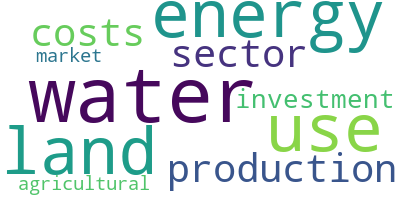

In [41]:
# Import the wordcloud library
long_string = ' '.join(df_topic_keywords.iloc[0, :].tolist()[:-1])# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=5, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()